## Bayesian Analysis of RCT Results
### C.V. Cosgriff

The [ANDROMEDA-SHOCK trial](https://jamanetwork.com/journals/jama/fullarticle/2724361) was recently published and has been a point of controversey. Despite results suggesting that capillary refill is safe, if not beneficial, when guiding treatment as compared to lactate level, the trial was deemed _negative_ based on the null-hypothesis testing framework that is standard across the current research literature.

A rich discussion ensued online and Dan Lane demonstrated a Bayesian analysis of the result [here](https://discourse.datamethods.org/t/andromeda-shock-or-how-to-intepret-hr-0-76-95-ci-0-55-1-02-p-0-06/1349/20) in `R` based on methods from [this paper](https://doi.org/10.1016/j.jclinepi.2008.07.006).

This notebook provides a `Python` implementation of Dan's code, examining the [ANDROMEDA-SHOCK trial](https://jamanetwork.com/journals/jama/fullarticle/2724361), and then applies the same approach to the [EOLIA trial](https://www.nejm.org/doi/full/10.1056/NEJMoa1800385). The latter has a more thorough Bayesian analysis published [here](https://www.ncbi.nlm.nih.gov/pubmed/30347031). The goal of this notebook is to provided clinicians keen on using this approach to interpret clinical trial results the requisite code.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using [Dan's post](https://discourse.datamethods.org/t/andromeda-shock-or-how-to-intepret-hr-0-76-95-ci-0-55-1-02-p-0-06/1349/20) and the appendix of [this paper](https://doi.org/10.1016/j.jclinepi.2008.07.006) as a guide, we implement functions for (1) representing a dichotomous outcome as normally distributed likelihood, (2) for representing the time-to-event outcome as a normally distributed likelihood, and (3) for calculating the posterior distribution from the prior and likelihood. The primary limitation of this method is the assumption of normal distribution of the parameters.

The definitions for the priors is also taken from [that paper](https://doi.org/10.1016/j.jclinepi.2008.07.006). Briefly, the skeptical prior has a mean of 0 and boundaries such that there is a 5% probability of exceeding the treatment effect that was assumed by the study investigators during sample size estimation, and the enthusiastic prior has a mean equal to the treatment effect assumed by the study investigators during sample size estimation and boundaries such that there is a 5% probability of no benefit.

_The code in function_ `get_prior` _may be modified to include other priors._

In [2]:
def odds_ratio(n, a, b):
    '''
    Given the sample size n, the number of those recieving intervention
    and experiencing the outcome a, and the number of those not receiving
    intervention (control) and experiencing the outcome b, an odds ratio
    is calculated.
    
    Input: n, sample size; float64
           a, the number of those recieving intervention
           and experiencing the outcome; float64
           b,  the number of those not receiving intervention 
           (control) and experiencing the outcome; float64
    Returns: An odds ratio; float64
    '''
    c = n - a
    d = n - b
    return ((a+0.5)*(d+0.5))/((b+0.5)*(c+0.5))

def get_prior(MCID, prior_type='skeptical'):
    '''
    Given the MCID expressed on the odds ratio scale a skeptical or enthusiastic
    prior is determined. The definition used for these is taken from 
    Journal of Clinical Epidemiology 62 (2009) 13-21.
    
    Input: MCID, an odds ratio representing the minimally clinically interesting
           difference.
           prior_type: 'enthusiastic', or 'uninformative'; type string, defualt is 'skeptical'
    Returns: (theta, sd) representing the prior; tuple of float64
    '''
    if (prior_type == 'skeptical'):
        return (0, np.log(MCID)/norm.ppf(0.05))
    if (prior_type == 'enthusiastic'):
        return (np.log(MCID), (np.log(1.05) - np.log(MCID))/norm.ppf(0.975))

def tte_to_likelihood(hazard_ratio, uc):
    '''
    Determines the parameters for a normal distribution
    based on the hazard ratio (HR) and 95% CI of said 
    HR from an RCT.
    
    Inputs: hazard ratio, upper 95% CI; both float64
    Returns: (theta, sd); a tuple of float64
    '''
    theta = np.log(hazard_ratio)
    sd = (np.log(uc) - theta)/norm.ppf(0.975)
    return (theta, sd)

def get_posterior(prior, likelihood):
    '''
    Determines the parameters the posterior distribution
    by combining a supplied prior and likelihood. Assumes
    all follow a normal distribution.
    
    Inputs: prior and likelihood; both a tuple of (theta, sd) of type float64
    Returns: tuple(theta, sd); a tuple of float64
    '''
    (prior_theta, prior_sd) = prior
    (L_theta, L_sd) = likelihood
    post_theta = ((prior_theta/prior_sd**2)+(L_theta/L_sd**2))/((1/prior_sd**2)+(1/L_sd**2))
    post_sd = np.sqrt(1/((1/prior_sd**2)+(1/L_sd**2)))
    return (post_theta, post_sd)

We'll also write a function for summarizing the result and generating plots for the prior, likelihood, and posterior distributions.

In [3]:
def summarize_distribution(distribution):
    '''
    Takes a posterior distribution and provides the median and 95% certainty 
    interval.
    
    Input: (theta, sd) representing the distribution; tuple of float64
    Return: None
    '''
    (theta, sd) = distribution
    dist_summary =  pd.DataFrame({' 2.5%' : [np.exp(norm.ppf(0.025, theta, sd))],
                                  '50.0%' : [np.exp(norm.ppf(0.5, theta, sd))],
                                  '97.5%' : [np.exp(norm.ppf(0.975, theta, sd))]},
                                 index=['Summaries'])
    prob_benefit = norm.cdf(0, theta, sd)
    display(dist_summary)
    print('The probability of any benefit (HR < 1.0) is: {0}'.format(round(prob_benefit, 3)))
    
def plot_bayes(prior, likelihood, posterior, title=None, save_file=False):
    '''
    Plots the prior, likelihood, and posterior distributions.
    
    Inputs: prior, likelihood, and posterior distribution; tuples of (theta, sd) both type float64
            title; string of text for title of plot
            save_file; boolean. if True saves the file as plot_bayes.svg
    Returns: None
    '''
    (prior_theta, prior_sd) = prior
    (L_theta, L_sd) = likelihood
    (post_theta, post_sd) = posterior
    
    mu_plot = np.arange(-2, 2, 0.001)
    prior_dist = norm.pdf(mu_plot, prior_theta, prior_sd)
    likelihood_dist = norm.pdf(mu_plot, L_theta, L_sd)
    posterior_dist = norm.pdf(mu_plot, post_theta, post_sd)
    
    figure = plt.figure(figsize=(8, 8))
    mu_plot = np.arange(-2, 2, 0.001)
    sns.lineplot(x=np.exp(mu_plot), y=np.exp(prior_dist), label='Prior')
    sns.lineplot(x=np.exp(mu_plot), y=np.exp(likelihood_dist), label='Likelihood')
    sns.lineplot(x=np.exp(mu_plot), y=np.exp(posterior_dist), label='Posterior')
    plt.xlim((0,2))
    plt.xlabel('Hazard Ratio')
    plt.ylabel('Probability Density')
    if (title != None):
        plt.title(title)
    if (save_file):
        plt.savefig('./plot_bayes.svg')

### Example 1: ANDROMEDA-SHOCK

In the ANDROMEDA-SHOCK trial the hazard ratio was 0.75 and the upper bound of the 95% confidence interval was 1.02; we use these to construct a likelihood.

In [4]:
L = tte_to_likelihood(0.75, 1.02)

We then use the numbers provided by the authors for the power calculation to express the minimally clinically interesting difference (MCID) as an odds ratio and use it to construct a skeptical prior.

In [5]:
n = 420 # Sample size
a = 0.3 * n # Intervention and Outcome
b = 0.45 * n # Control and Outcome

MCID = odds_ratio(n, a, b)
prior = get_prior(MCID, prior_type='skeptical')

We then use the `get_posterior` function to combine the prior and likelihood and visualize the result.

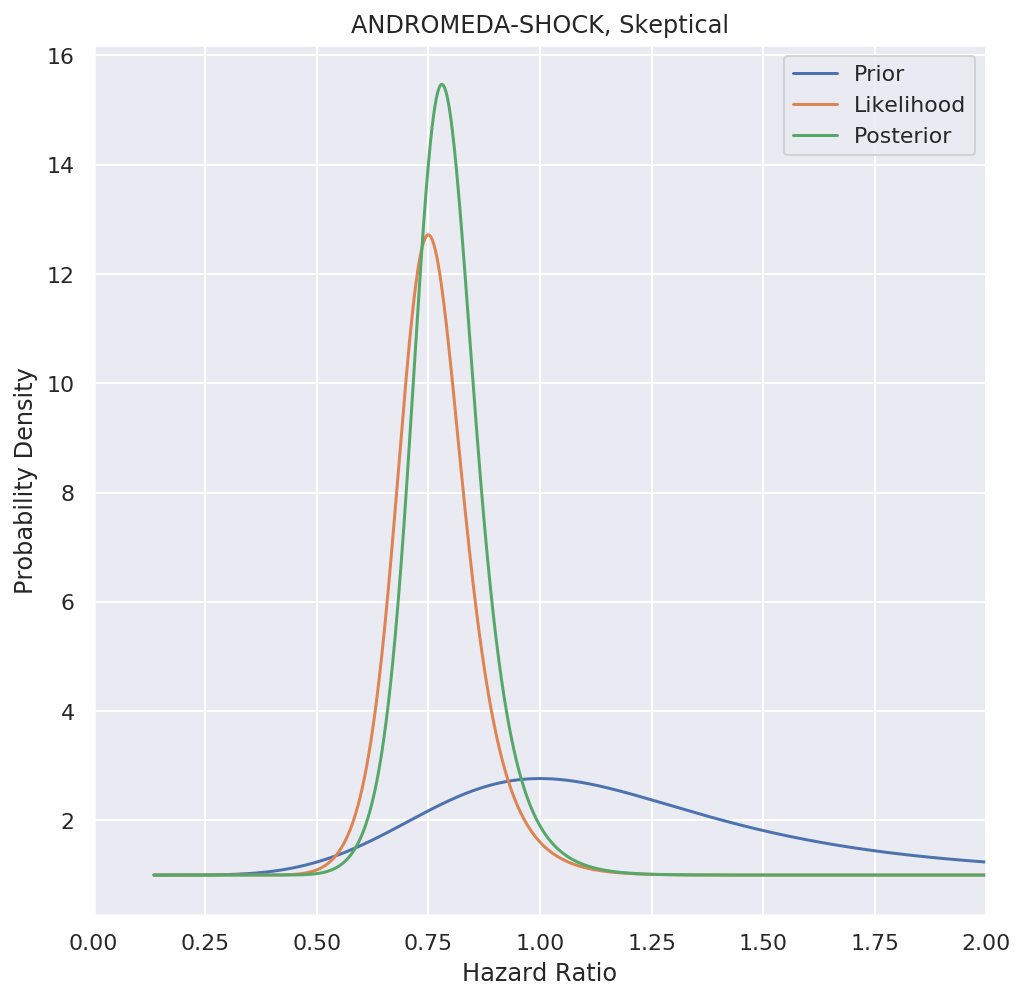

In [6]:
posterior = get_posterior(prior, L)
plot_bayes(prior, L, posterior, title='ANDROMEDA-SHOCK, Skeptical')

We then print the median and 95% certainty interval.

In [7]:
summarize_distribution(posterior)

,2.5%,50.0%,97.5%
Summaries,0.586579,0.780382,1.038215


The probability of any benefit (HR < 1.0) is: 0.956


We carry out the same calculations using an enthusiastic prior.

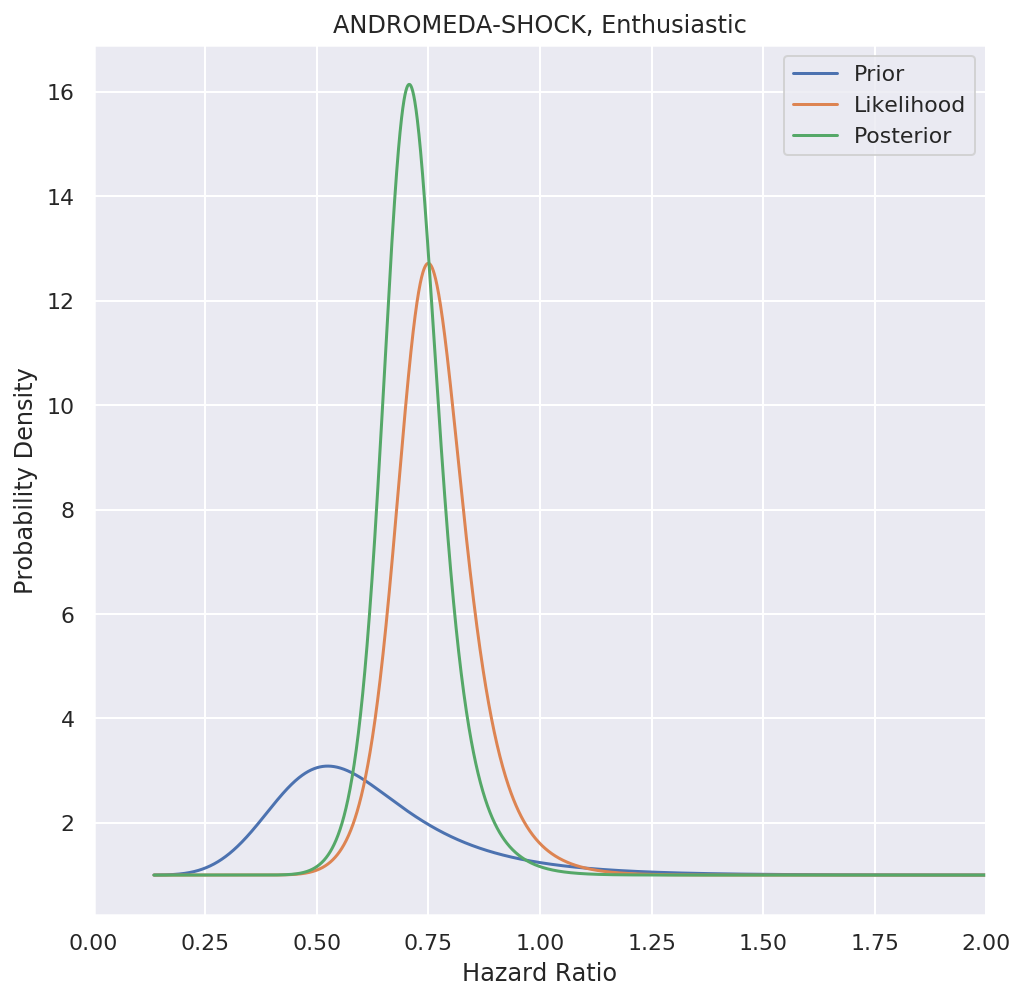

In [8]:
prior = get_prior(MCID, prior_type='enthusiastic')
posterior = get_posterior(prior, L)
plot_bayes(prior, L, posterior, title='ANDROMEDA-SHOCK, Enthusiastic')

In [9]:
summarize_distribution(posterior)

,2.5%,50.0%,97.5%
Summaries,0.533955,0.707271,0.936844


The probability of any benefit (HR < 1.0) is: 0.992


### Example 2: EOLIA

The EOLIA trial examined ECMO vs. ventilation alone and the result was determined to be a $HR = 0.76 [0.55, 1.04]$ for the outcome of death at 60 days from randomization.

In [10]:
L = tte_to_likelihood(0.76, 1.04)

Again, we use the provided numbers from the power calculation to derive the minimally clinically interesting difference (MCID) expressed as an odds ratio for constructing the priors; we first use a skeptical prior.

In [11]:
n = 331 # Sample size
a = 0.4 * n # Intervention and Outcome
b = 0.6 * n # Control and Outcome

MCID = odds_ratio(n, a, b)
prior = get_prior(MCID, prior_type='skeptical')

Then, as above, we determine the posterior and visualize the result.

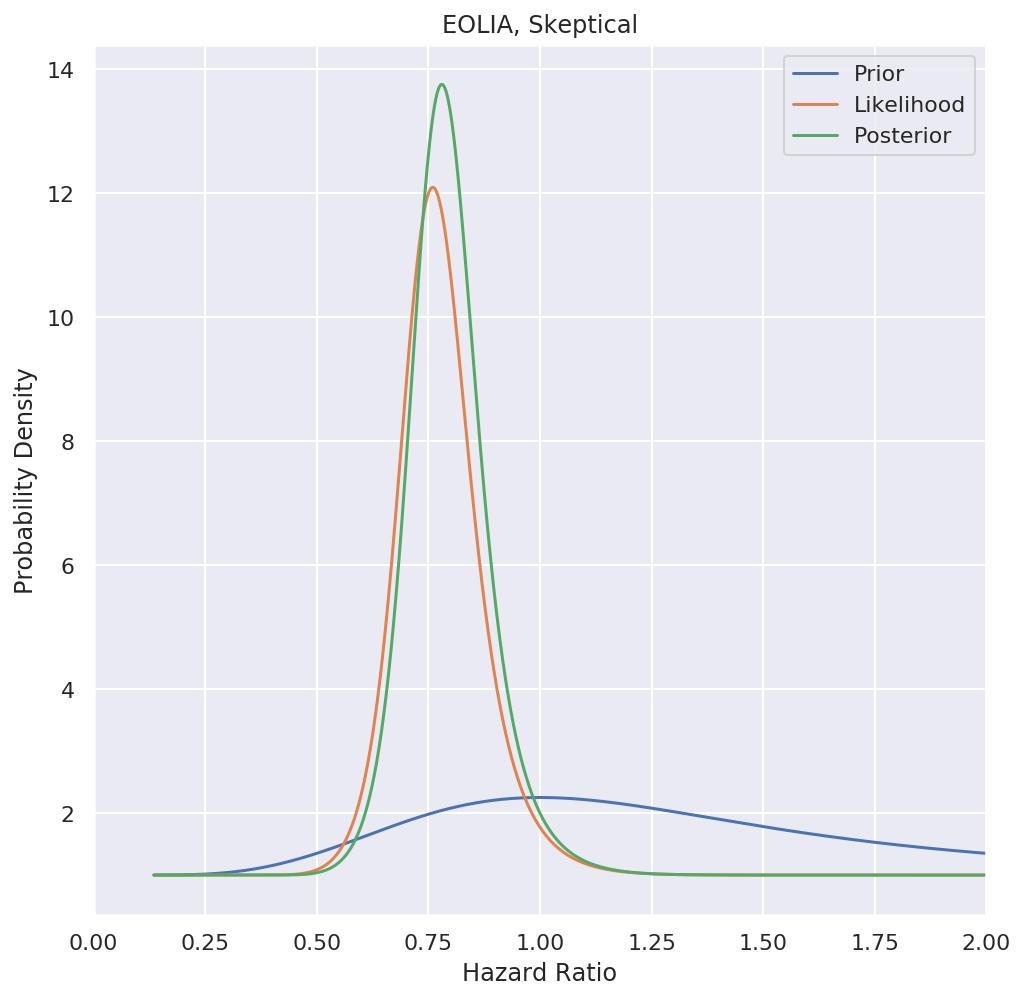

In [12]:
posterior = get_posterior(prior, L)
plot_bayes(prior, L, posterior, title='EOLIA, Skeptical')

In [13]:
summarize_distribution(posterior)

,2.5%,50.0%,97.5%
Summaries,0.579045,0.780259,1.051393


The probability of any benefit (HR < 1.0) is: 0.949


And now with an enthusiastic prior.

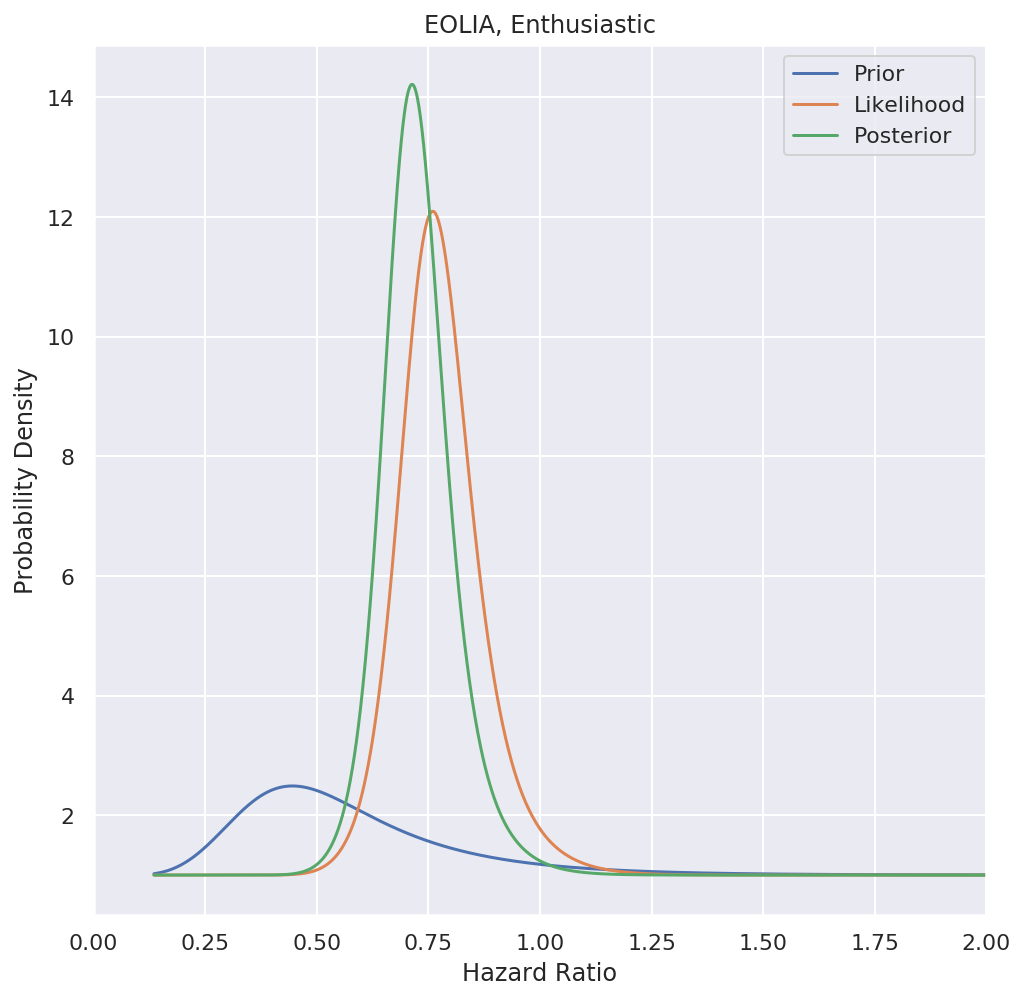

In [14]:
prior = get_prior(MCID, prior_type='enthusiastic')
posterior = get_posterior(prior, L)
plot_bayes(prior, L, posterior, title='EOLIA, Enthusiastic')

In [15]:
summarize_distribution(posterior)

,2.5%,50.0%,97.5%
Summaries,0.531503,0.71356,0.957978


The probability of any benefit (HR < 1.0) is: 0.988


These examples may serve as a template for analyzing other RCTs with the approach suggested by [Wijeysundera et al.](https://doi.org/10.1016/j.jclinepi.2008.07.006).